# MINI PROJECT 

**Data Source** https://www.kaggle.com/c/learn-ai-bbc/data  
**Github** https://github.com/cliff003/DTSA5510_mini

In [1]:
#import important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#EDA and preprocessing
import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from wordcloud import WordCloud

#modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.functional import softmax
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
import torch
import csv
from tqdm import tqdm


c:\Users\cliff\anaconda3\envs\python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#label file paths
current_dir = os.getcwd()
path_dir = os.path.join(current_dir, 'data/')
train_path = path_dir + 'BBC News Train.csv'
sample_solution_path = path_dir + 'BBC News Sample Solution.csv'
test_path = path_dir + 'BBC News Test.csv'

In [3]:
#import data
train = pd.read_csv(train_path)
sample_solution = pd.read_csv(sample_solution_path)
test = pd.read_csv(test_path)

________
# 1. Exploratory Analysis (EDA)
_____

In [4]:
# First few rows for trian data
train.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [5]:
# Summary of the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [6]:
# Statistical summary for numerical columns
train.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [7]:
# Check testing dataset
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [8]:
print(train['Category'].unique())

['business' 'tech' 'politics' 'sport' 'entertainment']


In [9]:
# Check for repeated articles in both train and test dataset
assert train['ArticleId'].nunique() == len(train)
assert test['ArticleId'].nunique() == len(test)

In [10]:

# Calculate number of articles for each category
category_counts = train['Category'].value_counts()
category_counts.head()


Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64

Now I would like to see what is the category distribution of the training data

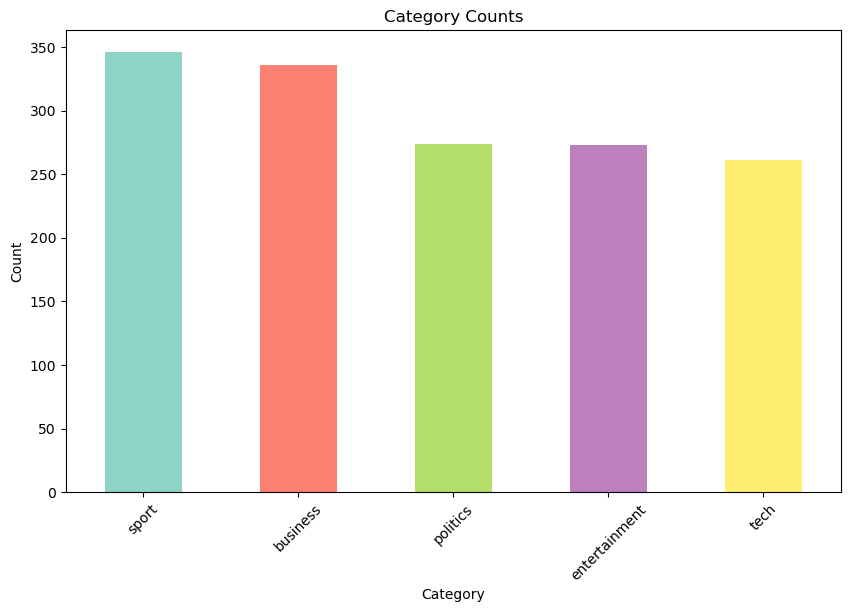

In [11]:
cmap = plt.get_cmap('Set3')
colors = cmap(np.linspace(0, 1, len(category_counts)))

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color=colors)
plt.title('Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

From this bar chart, the data is not perfectly balanced, it may affect future prediction result. But I choose not to manully balance this data, so it can retain as much as information it has.

Then, We can create a word cloud for better visualization. However, we need to clear the texts and remove stopwords for better look.

In [12]:
# Download stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word, tag in tagged_tokens if word not in stop_words and tag != 'VBD']
    text = ' '.join(filtered_tokens)
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cliff\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cliff\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cliff\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [13]:
# Make a copy of train dataset and apply clean_text function
train_clean = train.copy()
train_clean['Text'] = train_clean['Text'].apply(clean_text)

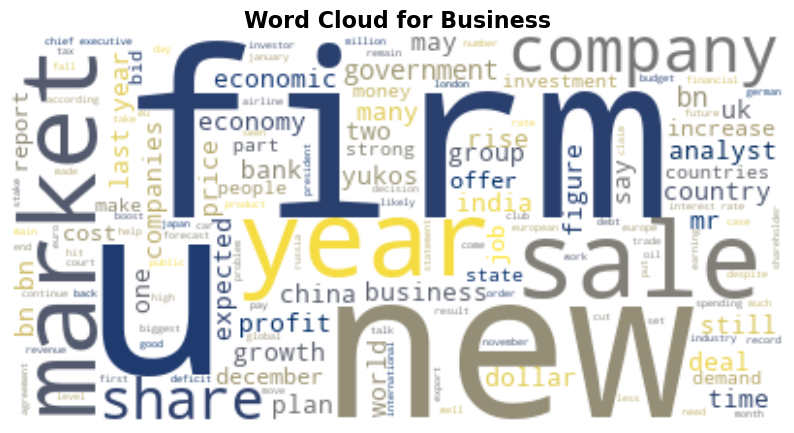

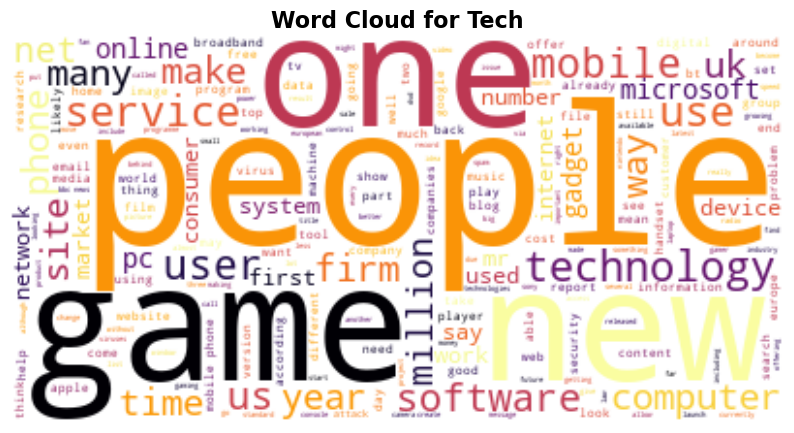

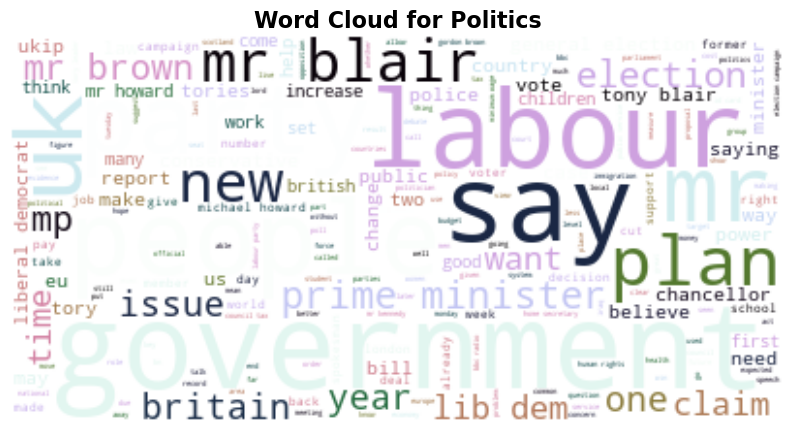

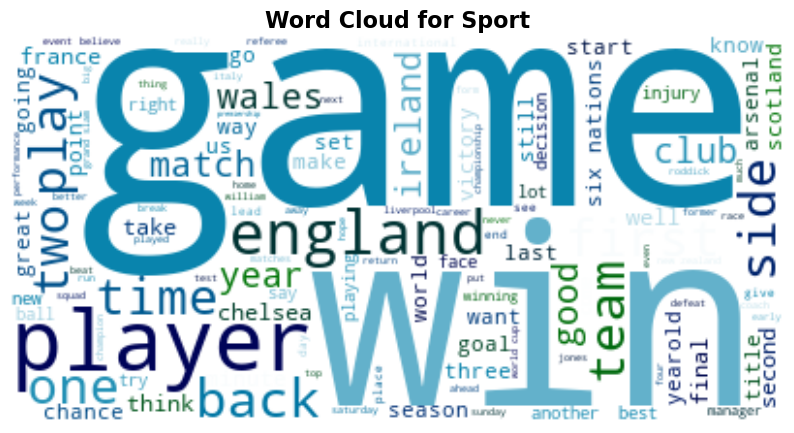

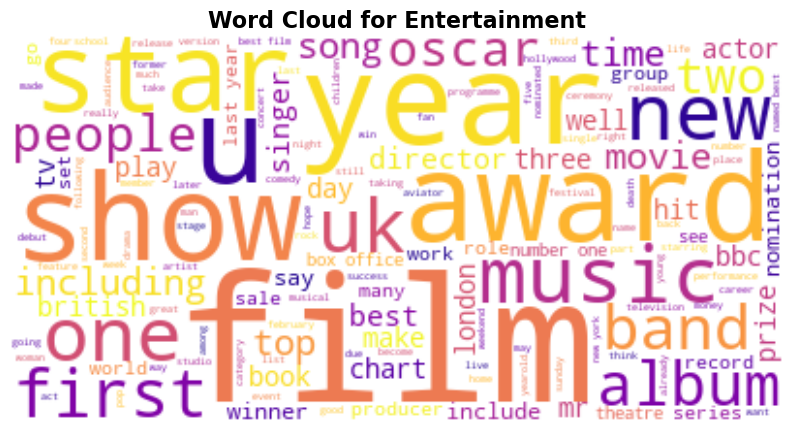

In [14]:
# Set up different color maps for different categories
category_colormaps = {
    'sport': 'ocean',
    'business': 'cividis',
    'politics': 'cubehelix',
    'entertainment': 'plasma',
    'tech': 'inferno'
}

# Construct word clouds
for category in train_clean['Category'].unique():
    text = " ".join(txt for txt in train_clean[train_clean['Category'] == category]['Text'])
    wordcloud = WordCloud(background_color="white", colormap=category_colormaps[category]).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {category.title()}", fontsize=16, fontweight='bold')
    plt.show()


We can easily recognize that there are different set of words in different word clouds. Therefore, we can try to use unsupervised machine learning to classify the categories.

-------
# 2. Model Building and Training 
-----



## 2.1 Unsupervised Model (Non-negative Matrix Factorization)

Using NMF method to classify different texts

In [15]:
X_train, X_val, y_train, y_val = train_test_split(train_clean['Text'], train_clean['Category'], test_size=0.2, random_state=0)

In [16]:
# Construct NMF model
tfidf_vectorizer = TfidfVectorizer(min_df = 2,
                          max_df = 0.95,
                          norm = 'l2',
                          stop_words = 'english')
train_tfidf = tfidf_vectorizer.fit_transform(X_train)
val_tfidf = tfidf_vectorizer.transform(X_val)

nmf_model = NMF(n_components=len(category_counts),beta_loss='kullback-leibler',solver='mu',l1_ratio=0)
train_nmf = nmf_model.fit_transform(train_tfidf)
val_nmf = nmf_model.transform(val_tfidf)

# Classifier
train_true = y_train
classifier = LogisticRegression()
classifier.fit(train_nmf, train_true)

# Prediction
train_pred = classifier.predict(train_nmf)
val_pred = classifier.predict(val_nmf)

train_accuracy = accuracy_score(train_true, train_pred)
val_accuracy = accuracy_score(y_val, val_pred)
train_f1 = f1_score(train_true, train_pred, average='weighted')
val_f1 = f1_score(y_val, val_pred, average='weighted')

print(f'Training Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}')

Training Accuracy: 0.9581, F1 Score: 0.9580
Validation Accuracy: 0.9732, F1 Score: 0.9731


In [17]:
test_clean = test.copy()
test_clean['Text'] = test_clean['Text'].apply(clean_text)

# Predict test dataset
test_tfidf = tfidf_vectorizer.transform(test_clean['Text'])
test_nmf = nmf_model.transform(test_tfidf)
test_pred = classifier.predict(test_nmf)
print(test_pred)

['sport' 'tech' 'sport' 'business' 'sport' 'sport' 'politics' 'politics'
 'entertainment' 'business' 'business' 'tech' 'politics' 'tech'
 'entertainment' 'sport' 'politics' 'tech' 'entertainment' 'politics'
 'business' 'politics' 'sport' 'business' 'business' 'sport' 'business'
 'sport' 'sport' 'business' 'politics' 'tech' 'business' 'business'
 'sport' 'sport' 'sport' 'business' 'entertainment' 'entertainment' 'tech'
 'politics' 'entertainment' 'tech' 'sport' 'tech' 'entertainment'
 'business' 'politics' 'business' 'politics' 'business' 'business'
 'business' 'tech' 'politics' 'tech' 'entertainment' 'sport' 'tech'
 'sport' 'entertainment' 'tech' 'politics' 'business' 'entertainment'
 'sport' 'tech' 'sport' 'sport' 'business' 'sport' 'business' 'politics'
 'tech' 'sport' 'tech' 'tech' 'tech' 'entertainment' 'politics' 'sport'
 'entertainment' 'entertainment' 'business' 'entertainment' 'business'
 'entertainment' 'business' 'tech' 'business' 'politics' 'sport' 'tech'
 'sport' 'sport' 's

In [18]:
# Prepare dataframe for submission
NMF_submission = pd.DataFrame(columns=['ArticleId', 'Category'])
NMF_submission['ArticleId'] = test['ArticleId']
NMF_submission['Category'] = test_pred

In [19]:
print(NMF_submission.head())
NMF_submission.to_csv('NMF_submission.csv', index=False)

   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


Here we can see the submission to the Kaggle competition, showing a score at 0.96054


<img src=https://raw.githubusercontent.com/cliff003/DTSA5510_mini/b9c68ca2bb65cd48bd8d872f1282317f5aa7921f/images/NMF_score.png width="600" alt="NMF Kaggle Submissions">


## 2.2 Supervised Model (BERT)

Bidirectional Encoder Representations from Transformers (BERT) is a state-of-art model used in NLP tasks, designed to handle a wide array of tasks such as text classification, question answering, and more. It is based on the Transformer architecture, which has significantly impacted NLP applications by enabling models to understand the context of words in a sentence more effectively.
The model used here is DistilBERT, introduced by Hugging Face, which is a smaller, faster, and lighter version of BERT that retains 97% of BERT's performance on language understanding benchmarks while being 40% smaller and 60% faster. Due to computational power restrction, this lighter version can be used on CPU only environment for this task.

Here is the architecture of DistilBERT:

<img src=https://raw.githubusercontent.com/cliff003/DTSA5510_mini/b9c68ca2bb65cd48bd8d872f1282317f5aa7921f/images/distilBERT.png width=1000 alt="architecture">  

*Image from Adel, Hadeer & Dahou, Abdelghani & Mabrouk, Alhassan & Elsayed Abd Elaziz, Mohamed & Kayed, Mohammed & El-henawy, Ibrahim & Alshathri, Samah & Ali, Abdelmgeid. (2022). Improving Crisis Events Detection Using DistilBERT with Hunger Games Search Algorithm. Mathematics. 10. 447. 10.3390/math10030447.*

In [20]:
class DistilBERTClassifier:
    """
    This class is designed for text classification tasks using the DistilBERT model, a lighter
    and faster version of the original BERT model optimized for speed and efficiency with minimal
    loss in accuracy. DistilBERTClassifier encapsulates functionalities including data preparation,
    model training, evaluation, and prediction.

    Key Features:
    - Initialization: Sets up the DistilBERT model, tokenizer, and training parameters.
    - Data Tokenization: Processes text for DistilBERT with tokenization, mask generation,
      and tensor conversion.
    - Training and Evaluation: Facilitates training across epochs, evaluates performance on
      a validation set, and adjusts learning rates dynamically.
    - Metrics Logging and Visualization: Allows saving of training metrics and visualization
      of the training progress to aid in model evaluation and tuning.
    - Prediction: Provides methods for predictions on new text inputs, simplifying model inference.

    The goal is to make the application of DistilBERT for text classification tasks more accessible,
    reducing the need for extensive boilerplate code.
    """
        
    def __init__(self, model_name='distilbert-base-uncased', num_labels=5, batch_size=4, epochs=5, lr=1e-5, eps=1e-8, max_length=256):
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)
        self.batch_size = batch_size
        self.epochs = epochs
        self.encoder = LabelEncoder()
        self.lr = lr
        self.eps = eps
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.model.to(self.device)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr, eps=self.eps)

        # Placeholder for keeping track of metrics
        self.train_losses = []
        self.val_losses = []
        self.val_f1_scores = []
        self.val_accuracies = []

    def tokenize_data(self, texts, labels=None):
        encoded_batch = self.tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_attention_mask=True,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoded_batch['input_ids']
        attention_masks = encoded_batch['attention_mask']

        if labels is not None:
            labels = torch.tensor(labels).long()
            dataset = TensorDataset(input_ids, attention_masks, labels)
        else:
            dataset = TensorDataset(input_ids, attention_masks)

        return dataset

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc="Training"):
            batch = [b.to(self.device) for b in batch]
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            self.optimizer.zero_grad()

            outputs = self.model(**inputs)
            loss = outputs[0]
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

        avg_loss = total_loss / len(dataloader)
        return avg_loss

    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        predictions, true_vals = [], []

        for batch in tqdm(dataloader, desc="Evaluation"):
            batch = [b.to(self.device) for b in batch]
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2]
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            loss = outputs[0]
            logits = outputs[1]
            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

        avg_loss = total_loss / len(dataloader)
        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)
        return avg_loss, predictions, true_vals

    def train(self, train_texts, train_labels, val_texts, val_labels):
        train_labels = self.encoder.fit_transform(train_labels)
        val_labels = self.encoder.fit_transform(val_labels)
        train_dataset = self.tokenize_data(train_texts, train_labels)
        val_dataset = self.tokenize_data(val_texts, val_labels)

        train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=self.batch_size)
        val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=self.batch_size//2)

        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * self.epochs)

        for epoch in range(self.epochs):
            print(f'\nEpoch {epoch + 1}/{self.epochs}')
            print('-' * 10)

            train_loss = self.train_epoch(train_dataloader)
            self.train_losses.append(train_loss)

            val_loss, predictions, true_vals = self.evaluate(val_dataloader)
            self.val_losses.append(val_loss)

            preds_flat = np.argmax(predictions, axis=1).flatten()
            labels_flat = true_vals.flatten()
            val_accuracy = accuracy_score(labels_flat, preds_flat)
            self.val_accuracies.append(val_accuracy)

            val_f1 = f1_score(np.argmax(predictions, axis=1), true_vals, average='weighted')
            self.val_f1_scores.append(val_f1)

            torch.save(self.model.state_dict(), f'DistilBERT_epoch{epoch+1}.model')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            print(f'F1 Score (Weighted): {val_f1}')

    def save_log(self, filename):
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Validation F1 Score', 'Validation Accuracy'])
            for epoch in range(self.epochs):
                writer.writerow([
                    epoch+1,
                    self.train_losses[epoch],
                    self.val_losses[epoch],
                    self.val_f1_scores[epoch],
                    self.val_accuracies[epoch]
            ])

    def plot_metrics(self, filename):
        # Read the training log
        df_log = pd.read_csv(filename)

        # Extract metrics
        epochs = df_log['Epoch']
        train_losses = df_log['Training Loss']
        val_losses = df_log['Validation Loss']
        val_f1_scores = df_log['Validation F1 Score']

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.plot(epochs, val_f1_scores, label='Validation F1 Score', linestyle='--')

        plt.title('Training and Validation Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict(self, texts, model_path=None):
        dataset = self.tokenize_data(texts)
        dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=1)
        if model_path != None:
            self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        predictions = []

        for batch in dataloader:
            batch = tuple(b.to(self.device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1]
            }

            with torch.no_grad():
                outputs = self.model(**inputs)

            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            predictions.append(logits)

        predictions = np.concatenate(predictions, axis=0)
        predicted_indices = np.argmax(predictions, axis=1)
        predicted_labels = self.encoder.inverse_transform(predicted_indices)
        return predicted_labels


In [21]:

num_labels = len(category_counts)
DistilBERT = DistilBERTClassifier(num_labels=num_labels, batch_size=8)
text = train['Text'].values

# Split train and validation
X_train, X_val, y_train, y_val = train_test_split(text, train['Category'], test_size=0.2, random_state=0)

# Train the model
DistilBERT.train(X_train, y_train, X_val, y_val)
DistilBERT.save_log('training_log.csv')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
----------


Evaluation: 100%|██████████| 75/75 [01:37<00:00,  1.30s/it]


Training Loss: 0.8882
Validation Loss: 0.2335, Validation Accuracy: 0.9832
F1 Score (Weighted): 0.9831833716260684

Epoch 2/5
----------


Evaluation: 100%|██████████| 75/75 [02:08<00:00,  1.72s/it]


Training Loss: 0.1520
Validation Loss: 0.1043, Validation Accuracy: 0.9732
F1 Score (Weighted): 0.9731358363787659

Epoch 3/5
----------


Evaluation: 100%|██████████| 75/75 [01:58<00:00,  1.58s/it]


Training Loss: 0.0542
Validation Loss: 0.0400, Validation Accuracy: 0.9866
F1 Score (Weighted): 0.9865614126247783

Epoch 4/5
----------


Evaluation: 100%|██████████| 75/75 [01:36<00:00,  1.28s/it]


Training Loss: 0.0253
Validation Loss: 0.0737, Validation Accuracy: 0.9832
F1 Score (Weighted): 0.9831974714690084

Epoch 5/5
----------


Evaluation: 100%|██████████| 75/75 [01:36<00:00,  1.28s/it]


Training Loss: 0.0136
Validation Loss: 0.0362, Validation Accuracy: 0.9866
F1 Score (Weighted): 0.9865614126247783


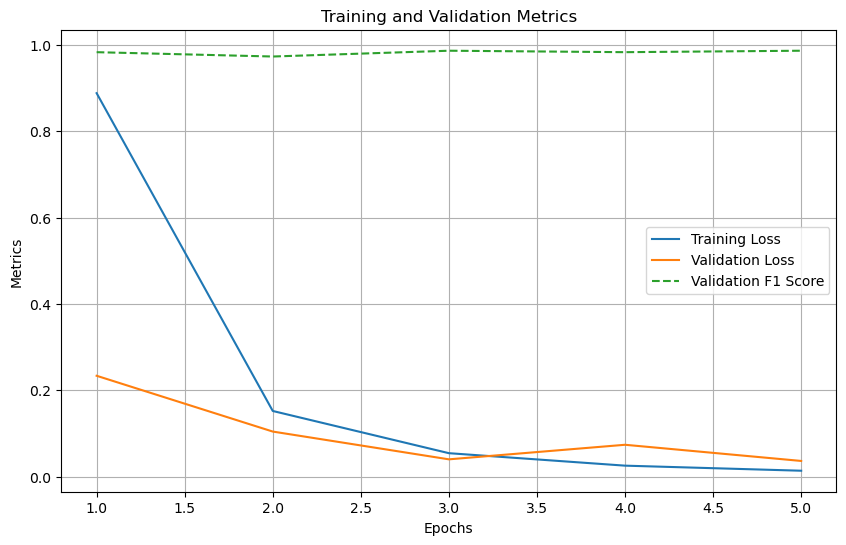

In [22]:
# Plot Metrics vs Epochs
DistilBERT.plot_metrics('training_log.csv')

In [23]:
# Predict on new data
predictions = DistilBERT.predict(list(test['Text']))
print(predictions)

['sport' 'tech' 'sport' 'business' 'sport' 'sport' 'politics' 'politics'
 'entertainment' 'business' 'business' 'tech' 'politics' 'tech'
 'entertainment' 'sport' 'politics' 'tech' 'entertainment' 'entertainment'
 'business' 'politics' 'sport' 'business' 'politics' 'sport' 'business'
 'sport' 'sport' 'business' 'politics' 'tech' 'business' 'business'
 'sport' 'sport' 'sport' 'business' 'entertainment' 'entertainment' 'tech'
 'politics' 'entertainment' 'tech' 'sport' 'tech' 'entertainment'
 'business' 'politics' 'business' 'politics' 'business' 'business'
 'business' 'tech' 'politics' 'tech' 'entertainment' 'sport' 'tech'
 'sport' 'entertainment' 'tech' 'politics' 'business' 'entertainment'
 'sport' 'tech' 'sport' 'sport' 'tech' 'sport' 'business' 'politics'
 'tech' 'sport' 'tech' 'tech' 'tech' 'entertainment' 'politics' 'sport'
 'entertainment' 'entertainment' 'business' 'entertainment' 'business'
 'entertainment' 'business' 'tech' 'politics' 'politics' 'sport' 'tech'
 'sport' 'sport' '

In [24]:
# Prepare dataframe for submission
BERT_submission = pd.DataFrame(columns=['ArticleId', 'Category'])
BERT_submission['ArticleId'] = test['ArticleId']
BERT_submission['Category'] = predictions

print(BERT_submission.head())
BERT_submission.to_csv('BERT_submission.csv', index=False)


   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


Here we can see the submission to the Kaggle competition, showing a score at 0.98367, which beats the No.1 on the leaderborad without fine-tuning.  
Transformer based models are dominating modern NLP tasks.


<img src=https://raw.githubusercontent.com/cliff003/DTSA5510_mini/b9c68ca2bb65cd48bd8d872f1282317f5aa7921f/images/BERT_score.png width="600" alt="BERT Kaggle Submissions">  

Another intersting thing is that the uncleaned text (with stopwords) works better in distilBERT model. Because the relationship between text are essential when passthough attention mechnisims. The future of NLP is changing rapidly with new machine learning models.


_______
# 3. Model Comparisons 

We can compare NMF model with distilBERT with different amount of data. So, we can check which one has better overall performance.

## 3.1 NMF model

In [25]:
def NMF_compare(num=10, seed=0, sub=True):
    full_data = train_clean.copy()

    # Lists to store metrics
    training_accuracies, validation_accuracies, validation_f1_scores = [], [], []

    # Fractions of data to use
    data_fractions = np.linspace(0.1, 1.0, num)

    for fraction in data_fractions:
        # Sample a fraction of the full dataset
        sampled_data = full_data.sample(frac=fraction, random_state=seed)

        # Split sampled data into text and labels
        X = sampled_data['Text']
        y = sampled_data['Category']

        # Split sampled data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

        # TF-IDF Vectorization
        train_tfidf = tfidf_vectorizer.fit_transform(X_train)
        val_tfidf = tfidf_vectorizer.transform(X_val)

        # NMF Transformation
        train_nmf = nmf_model.fit_transform(train_tfidf)
        val_nmf = nmf_model.transform(val_tfidf)

        # Train Logistic Regression Classifier
        classifier.fit(train_nmf, y_train)

        # Prediction and Evaluation
        train_pred = classifier.predict(train_nmf)
        val_pred = classifier.predict(val_nmf)
        train_accuracy = accuracy_score(y_train, train_pred)
        val_accuracy = accuracy_score(y_val, val_pred)
        val_f1 = f1_score(y_val, val_pred, average='weighted')

        # Store metrics
        training_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)
        validation_f1_scores.append(val_f1)

        # Predict test dataset
        test_tfidf = tfidf_vectorizer.transform(test_clean['Text'])
        test_nmf = nmf_model.transform(test_tfidf)
        test_pred = classifier.predict(test_nmf)

        if sub:
            # Make different submission files
            NMF_submission = pd.DataFrame(columns=['ArticleId', 'Category'])
            NMF_submission['ArticleId'] = test['ArticleId']
            NMF_submission['Category'] = test_pred
            NMF_submission.to_csv(f'NMF_submission_{int(fraction*100)}%.csv', index=False)

    return training_accuracies, validation_accuracies, validation_f1_scores, data_fractions

In [26]:
training_accuracies, validation_accuracies, validation_f1_scores, data_fractions = NMF_compare()

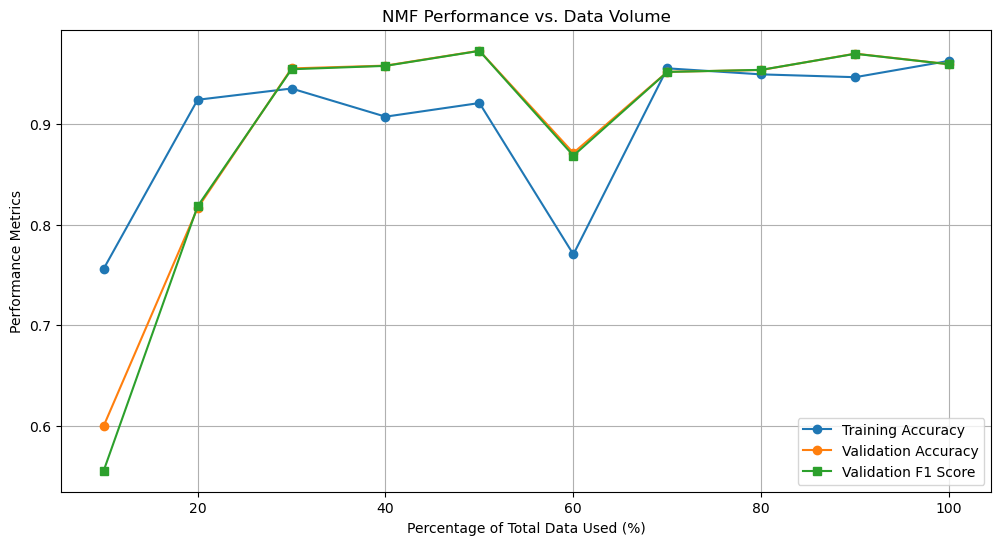

In [27]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data_fractions * 100, training_accuracies, '-o', label='Training Accuracy')
plt.plot(data_fractions * 100, validation_accuracies, '-o', label='Validation Accuracy')
plt.plot(data_fractions * 100, validation_f1_scores, '-s', label='Validation F1 Score')
plt.title('NMF Performance vs. Data Volume')
plt.xlabel('Percentage of Total Data Used (%)')
plt.ylabel('Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

We can see from the plot that when more data are used, the performance increasing.
However,the data point at 60% has a anormaly, this may because of the imbalance of the data. So when I split it, it will become more imbalanced in certain way.  
This is a small dataset, so it happens more often. The plot will be different if the random state is changed.

Here we can see the submissions to the Kaggle competition, showing a similar trend as the plot.  


<img src=https://raw.githubusercontent.com/cliff003/DTSA5510_mini/b9c68ca2bb65cd48bd8d872f1282317f5aa7921f/images/NMF_scores.png width="600" alt="NMF Kaggle Submissions">


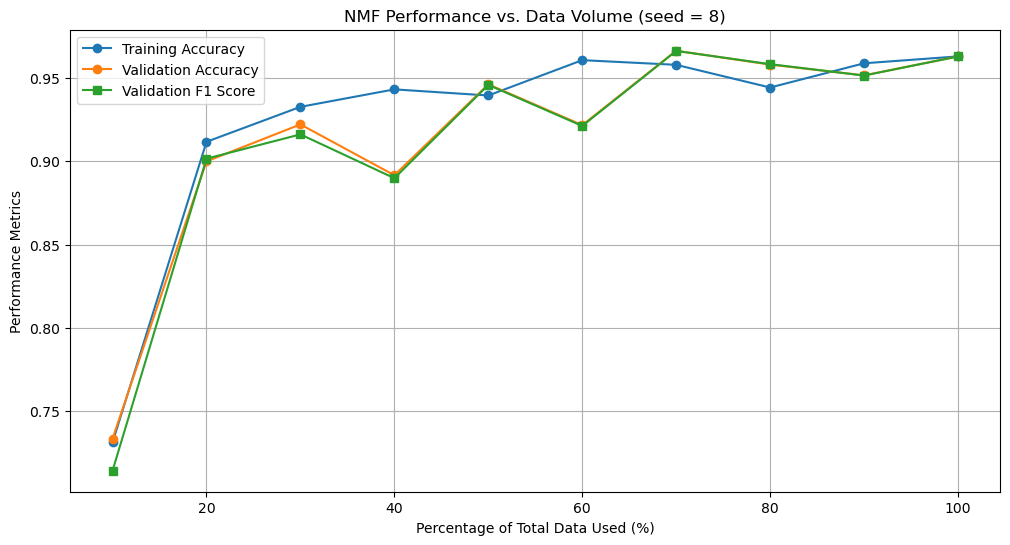

In [28]:
training_accuracies, validation_accuracies, validation_f1_scores, data_fractions = NMF_compare(seed=8, sub=False)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data_fractions * 100, training_accuracies, '-o', label='Training Accuracy')
plt.plot(data_fractions * 100, validation_accuracies, '-o', label='Validation Accuracy')
plt.plot(data_fractions * 100, validation_f1_scores, '-s', label='Validation F1 Score')
plt.title('NMF Performance vs. Data Volume (seed = 8)')
plt.xlabel('Percentage of Total Data Used (%)')
plt.ylabel('Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

This plot shows a smoothier trend when I adjust the seed.

## 3.2 DistilBERT model  
From previous training, I found 3 epochs will reach an optimal result, so I would like to use only 3 epochs to do the comparison.

In [29]:
def distilBERT_compare(num=10, seed=0, sub=True, epochs=3, batch_size=4):
    full_data = train.copy()

    # Lists to store metrics
    BERT_training_losses, BERT_validation_accuracies, BERT_validation_f1_scores = [], [], []

    # Fractions of data to use
    data_fractions = np.linspace(0.1, 1.0, 10)

    for fraction in data_fractions:
        # Sample a fraction of the full dataset
        sampled_data = full_data.sample(frac=fraction, random_state=seed)

        # Split sampled data into text and labels
        X = sampled_data['Text']
        y = sampled_data['Category']

        # Split sampled data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

        num_labels = len(category_counts)
        DistilBERT = DistilBERTClassifier(num_labels=num_labels, epochs=epochs, batch_size=batch_size)

        # Train the model
        DistilBERT.train(X_train, y_train, X_val, y_val)

        log_name = f'training_log_{int(fraction*100)}%.csv'
        DistilBERT.save_log(log_name)
        log_df = pd.read_csv(log_name)

        max_val_row = log_df.loc[log_df['Validation Accuracy'].idxmax()]

        val_accuracy = max_val_row['Validation Accuracy']
        train_loss = max_val_row['Training Loss']
        epoch = max_val_row['Epoch']
        val_f1 = max_val_row['Validation F1 Score']

        # Store metrics
        BERT_training_losses.append(train_loss)
        BERT_validation_accuracies.append(val_accuracy)
        BERT_validation_f1_scores.append(val_f1)

        # Predict test dataset
        test_pred = DistilBERT.predict(test['Text'].values)

        if sub:
            # Make different submission files
            BERT_submission = pd.DataFrame(columns=['ArticleId', 'Category'])
            BERT_submission['ArticleId'] = test['ArticleId']
            BERT_submission['Category'] = test_pred
            BERT_submission.to_csv(f'BERT_submission_{int(fraction*100)}%.csv', index=False)
        
    return  BERT_training_losses, BERT_validation_accuracies, BERT_validation_f1_scores, data_fractions

In [30]:
BERT_training_losses, BERT_validation_accuracies, BERT_validation_f1_scores, data_fractions = distilBERT_compare(batch_size=8)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Training Loss: 1.5793
Validation Loss: 1.5398, Validation Accuracy: 0.4000
F1 Score (Weighted): 0.4977777777777778

Epoch 2/3
----------


Evaluation: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Training Loss: 1.4229
Validation Loss: 1.3704, Validation Accuracy: 0.7667
F1 Score (Weighted): 0.8296825396825397

Epoch 3/3
----------


Evaluation: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]


Training Loss: 1.2155
Validation Loss: 1.1596, Validation Accuracy: 0.9333
F1 Score (Weighted): 0.9388694638694638


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Training Loss: 1.5401
Validation Loss: 1.4150, Validation Accuracy: 0.8000
F1 Score (Weighted): 0.8177289377289376

Epoch 2/3
----------


Evaluation: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Training Loss: 1.1844
Validation Loss: 1.0068, Validation Accuracy: 0.9833
F1 Score (Weighted): 0.9832915622389307

Epoch 3/3
----------


Evaluation: 100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Training Loss: 0.7760
Validation Loss: 0.6161, Validation Accuracy: 0.9667
F1 Score (Weighted): 0.9664115243062612


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 23/23 [00:30<00:00,  1.33s/it]


Training Loss: 1.4707
Validation Loss: 1.1796, Validation Accuracy: 0.9444
F1 Score (Weighted): 0.9454932982758361

Epoch 2/3
----------


Evaluation: 100%|██████████| 23/23 [00:30<00:00,  1.32s/it]


Training Loss: 0.9006
Validation Loss: 0.5884, Validation Accuracy: 0.9556
F1 Score (Weighted): 0.9556733571045165

Epoch 3/3
----------


Evaluation: 100%|██████████| 23/23 [00:27<00:00,  1.19s/it]


Training Loss: 0.4335
Validation Loss: 0.2803, Validation Accuracy: 0.9667
F1 Score (Weighted): 0.9668820630286957


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Training Loss: 1.3961
Validation Loss: 1.0201, Validation Accuracy: 0.8583
F1 Score (Weighted): 0.8793358840363319

Epoch 2/3
----------


Evaluation: 100%|██████████| 30/30 [00:36<00:00,  1.22s/it]


Training Loss: 0.6942
Validation Loss: 0.4360, Validation Accuracy: 0.9500
F1 Score (Weighted): 0.950808853657428

Epoch 3/3
----------


Evaluation: 100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


Training Loss: 0.2709
Validation Loss: 0.2085, Validation Accuracy: 0.9583
F1 Score (Weighted): 0.95897370055771


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 38/38 [00:44<00:00,  1.17s/it]


Training Loss: 1.2743
Validation Loss: 0.7662, Validation Accuracy: 0.9530
F1 Score (Weighted): 0.9534235424461913

Epoch 2/3
----------


Evaluation: 100%|██████████| 38/38 [00:51<00:00,  1.36s/it]


Training Loss: 0.4737
Validation Loss: 0.2577, Validation Accuracy: 0.9530
F1 Score (Weighted): 0.9532184101498827

Epoch 3/3
----------


Evaluation: 100%|██████████| 38/38 [00:44<00:00,  1.17s/it]


Training Loss: 0.1472
Validation Loss: 0.1520, Validation Accuracy: 0.9732
F1 Score (Weighted): 0.9730872247416122


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 45/45 [00:52<00:00,  1.17s/it]


Training Loss: 1.1973
Validation Loss: 0.6130, Validation Accuracy: 0.9609
F1 Score (Weighted): 0.9607834277137782

Epoch 2/3
----------


Evaluation: 100%|██████████| 45/45 [00:52<00:00,  1.16s/it]


Training Loss: 0.3593
Validation Loss: 0.2001, Validation Accuracy: 0.9553
F1 Score (Weighted): 0.9549551664241116

Epoch 3/3
----------


Evaluation: 100%|██████████| 45/45 [00:53<00:00,  1.19s/it]


Training Loss: 0.1067
Validation Loss: 0.1433, Validation Accuracy: 0.9665
F1 Score (Weighted): 0.9662972309703385


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 53/53 [01:01<00:00,  1.16s/it]


Training Loss: 1.1539
Validation Loss: 0.5081, Validation Accuracy: 0.9569
F1 Score (Weighted): 0.9571769563228844

Epoch 2/3
----------


Evaluation: 100%|██████████| 53/53 [01:00<00:00,  1.15s/it]


Training Loss: 0.2646
Validation Loss: 0.1892, Validation Accuracy: 0.9522
F1 Score (Weighted): 0.9527706119493203

Epoch 3/3
----------


Evaluation: 100%|██████████| 53/53 [01:01<00:00,  1.17s/it]


Training Loss: 0.0849
Validation Loss: 0.1578, Validation Accuracy: 0.9617
F1 Score (Weighted): 0.9619802217314529


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 60/60 [01:08<00:00,  1.14s/it]


Training Loss: 1.0468
Validation Loss: 0.3922, Validation Accuracy: 0.9498
F1 Score (Weighted): 0.9509505877664873

Epoch 2/3
----------


Evaluation: 100%|██████████| 60/60 [01:21<00:00,  1.36s/it]


Training Loss: 0.2040
Validation Loss: 0.0985, Validation Accuracy: 0.9874
F1 Score (Weighted): 0.9874645749780911

Epoch 3/3
----------


Evaluation: 100%|██████████| 60/60 [01:10<00:00,  1.18s/it]


Training Loss: 0.0684
Validation Loss: 0.0894, Validation Accuracy: 0.9749
F1 Score (Weighted): 0.9748587206224896


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 68/68 [01:19<00:00,  1.17s/it]


Training Loss: 0.9707
Validation Loss: 0.3035, Validation Accuracy: 0.9703
F1 Score (Weighted): 0.9703618503639075

Epoch 2/3
----------


Evaluation: 100%|██████████| 68/68 [01:15<00:00,  1.11s/it]


Training Loss: 0.1622
Validation Loss: 0.0742, Validation Accuracy: 0.9851
F1 Score (Weighted): 0.9851184794753455

Epoch 3/3
----------


Evaluation: 100%|██████████| 68/68 [01:16<00:00,  1.13s/it]


Training Loss: 0.0539
Validation Loss: 0.1010, Validation Accuracy: 0.9628
F1 Score (Weighted): 0.9628979755721081


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
----------


Evaluation: 100%|██████████| 75/75 [01:27<00:00,  1.16s/it]


Training Loss: 0.8752
Validation Loss: 0.2667, Validation Accuracy: 0.9597
F1 Score (Weighted): 0.9598032756055568

Epoch 2/3
----------


Evaluation: 100%|██████████| 75/75 [01:29<00:00,  1.19s/it]


Training Loss: 0.1304
Validation Loss: 0.1181, Validation Accuracy: 0.9698
F1 Score (Weighted): 0.9700315721819095

Epoch 3/3
----------


Evaluation: 100%|██████████| 75/75 [01:28<00:00,  1.18s/it]


Training Loss: 0.0537
Validation Loss: 0.1060, Validation Accuracy: 0.9732
F1 Score (Weighted): 0.9732542618212613


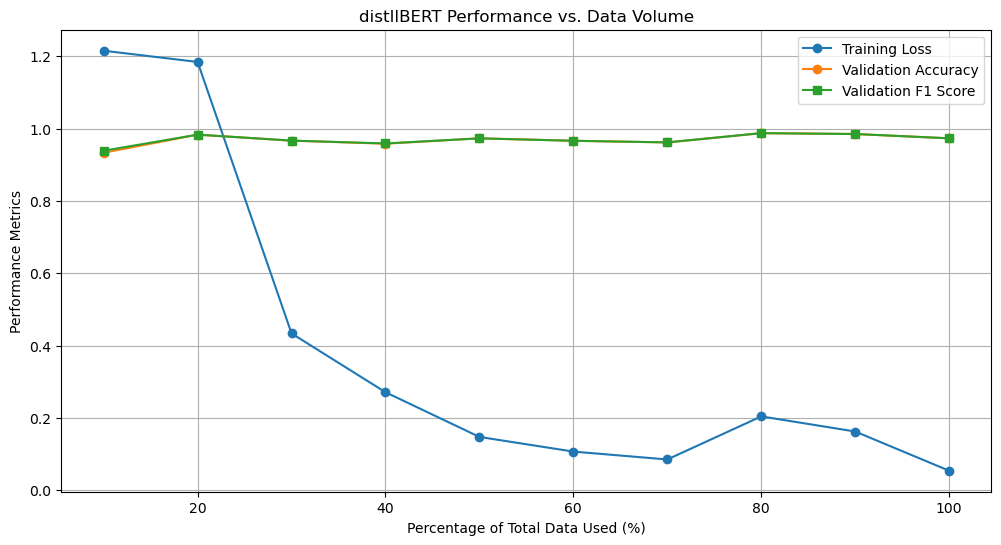

In [31]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data_fractions * 100, BERT_training_losses, '-o', label='Training Loss')
plt.plot(data_fractions * 100, BERT_validation_accuracies, '-o', label='Validation Accuracy')
plt.plot(data_fractions * 100, BERT_validation_f1_scores, '-s', label='Validation F1 Score')
plt.title('distllBERT Performance vs. Data Volume')
plt.xlabel('Percentage of Total Data Used (%)')
plt.ylabel('Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()

The training loss of DistilBERT shows that it has a dramatic improvement when we have more data.  
For validation accuracy, since the test data is very small, I got very high accuracy, and the kaggle submission proves that.

<img src=https://raw.githubusercontent.com/cliff003/DTSA5510_mini/b9c68ca2bb65cd48bd8d872f1282317f5aa7921f/images/BERT_scores.png width="600" alt="DistilBERT Kaggle Submissions">  

The highest score is 0.98503, which is higher than previous 5 epoch model. More epochs may result in overfitting the data, and low train loss may not always be good for the entire dataset.


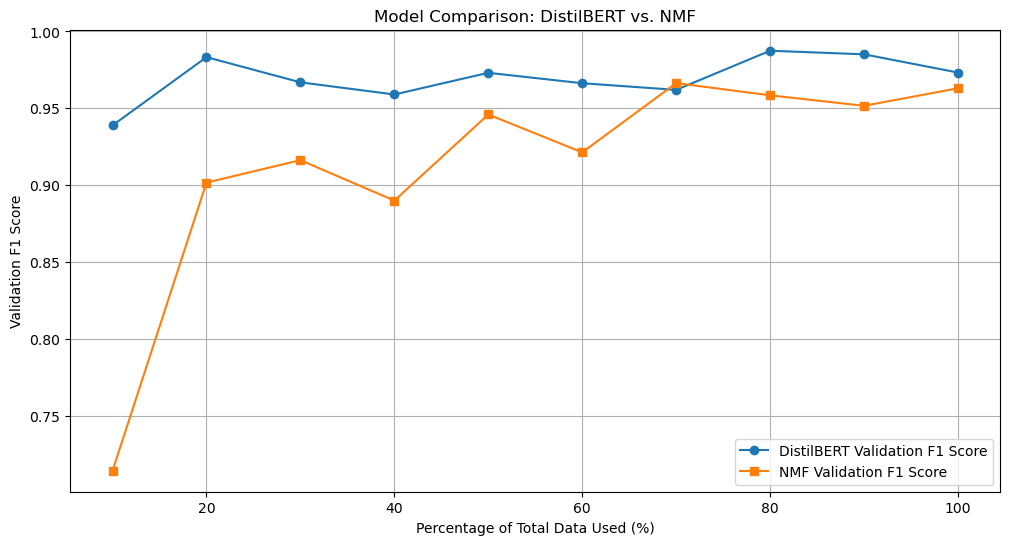

In [32]:
# Compare NMF model and Distil BERT
plt.figure(figsize=(12, 6))

plt.plot(data_fractions * 100, BERT_validation_f1_scores, '-o', label='DistilBERT Validation F1 Score')
plt.plot(data_fractions * 100, validation_f1_scores, '-s', label='NMF Validation F1 Score')

plt.title('Model Comparison: DistilBERT vs. NMF')
plt.xlabel('Percentage of Total Data Used (%)')
plt.ylabel('Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()


Here is the comparison between these data. Although DistilBERT has much better performance, NMF models can still beat DistilBert at some point.  
I think for future NLP tasks, NMF models can be used before head to reduce dimension. With new models like BERT and GPT take care of the rest of the work.

______ 
# 4. Conclusions
______



### 1. The NMF model
NMF(Non-negative Matrix Factorization) is a unsupervised model, with proper tuning, it can classify text accurately and quickly.  
The running time of this algorithm is so fast when we dealing with thousands of data.  
However, it requires a lot of data cleaning beforehead. Which makes it less general to all kind of data. Data scientists must clean the text carefully before apply unsupervised models.  
When compare it with supervised models, it does not require labeling, which is very useful in specific tasks.



### 2. BERT model

BERT(Bidirectional Encoder Representations from Transformers) is a pre-trained model. That is the reason why the kaggle submission result is much better than NMF. It can handle classification easily, with the cost of very high computational power. The training time is significant longer than NMF models.  
With modern chips and graphic cards, computation power is increased dramatically. Therefore, this method is widely used and it is very versatile. Transformer basd models can benefit from contextual understanding, so we can use raw text to train the model. This will reduce the need of text cleaning steps significantly. And it will have higher performance when we use raw texts(including stopwords).
In addition, it is very powerful and can be used on many other NLP tasks, classification tasks are too 'easy' for this larhge and complex model.  
Finally, BERT's advanced capabilities for understanding and generating language make it suitable for a wide range of NLP tasks, offering superior performance in many cases.

### 3. Difference between two models

| Feature                          | BERT                                                    | NMF                                                     |
|----------------------------------|---------------------------------------------------------|---------------------------------------------------------|
| **Understanding**                | Deep contextual understanding of language.              | Analyzes documents to find latent topics.               |
| **Pre-trained Knowledge**        | Utilizes pre-training on a large corpus.                | Does not use pre-training.                              |
| **Task Flexibility**             | Versatile, suitable for a wide range of NLP tasks.      | Primarily used for topic modeling and feature extraction.|
| **Performance on Complex Tasks** | Excels in tasks requiring deep language understanding. | Useful for identifying document topics, less effective for complex NLP tasks. |
| **Model Complexity**             | Large and complex, requires significant computation.    | Simpler, less resource-intensive.                       |
| **Resources Required**           | Requires GPUs for efficient training and inference.     | Can be run on standard computers without specialized hardware. |
| **Use Cases**                    | Sentiment analysis, question answering, named entity recognition, etc. | Document clustering, dimensionality reduction, topic discovery. |
| **Training Approach**            | Fine-tuning on specific tasks after pre-training.       | Applied directly to the dataset without pre-training.   |
| **Learning Paradigm**            | Supervised (requires labeling for fine-tuning) or semi-supervised. | Unsupervised (does not require labeled data).          |


# THANK YOU FOR READING!